In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Check if using TensorFlow 2.4')
print('Using TensorFlow version', tf.__version__)

Check if using TensorFlow 2.4
Using TensorFlow version 2.9.2


In [3]:
path = "/content/drive/MyDrive/icons/"
print(os.listdir(path))

['book.png', 'test-plane-2.png', 'knife.png', 'test-knife.png', 'owl.png', 'plane.png', 'test-owl.png', 'test-plane.png', 'train.png', 'lion.png', 'monkey.png', 'test-monkey.png', 'test-monkey-3.png', 'test-monkey-2.png', 'model', 'model.h5', 'icons_model', '2sec.mp4', 'labels.csv', 'icon.h5']


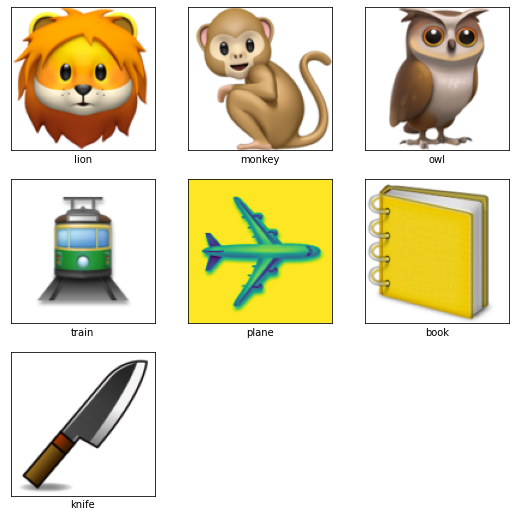

In [4]:
icons = {
    0: {'name': 'lion', 'file': path+'lion.png'},
    1: {'name': 'monkey', 'file': path+'monkey.png'},
    2: {'name': 'owl', 'file': path+'owl.png'},
    3: {'name': 'train', 'file': path+'train.png'},
    4: {'name': 'plane', 'file': path+'plane.png'},
    5: {'name': 'book', 'file': path+'book.png'},
    6: {'name': 'knife', 'file': path+'knife.png'},
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(icons.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('icons', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [5]:
for class_id, values in icons.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    icons[class_id]['image'] = new_file

In [6]:
icons

{0: {'name': 'lion',
  'file': '/content/drive/MyDrive/icons/lion.png',
  'image': <PIL.Image.Image image mode=RGB size=120x120 at 0x7F2979D254D0>},
 1: {'name': 'monkey',
  'file': '/content/drive/MyDrive/icons/monkey.png',
  'image': <PIL.Image.Image image mode=RGB size=120x120 at 0x7F2978478D90>},
 2: {'name': 'owl',
  'file': '/content/drive/MyDrive/icons/owl.png',
  'image': <PIL.Image.Image image mode=RGB size=120x120 at 0x7F297A31B690>},
 3: {'name': 'train',
  'file': '/content/drive/MyDrive/icons/train.png',
  'image': <PIL.Image.Image image mode=RGB size=120x120 at 0x7F2978478310>},
 4: {'name': 'plane',
  'file': '/content/drive/MyDrive/icons/plane.png',
  'image': <PIL.Image.Image image mode=RGB size=120x120 at 0x7F2978472210>},
 5: {'name': 'book',
  'file': '/content/drive/MyDrive/icons/book.png',
  'image': <PIL.Image.Image image mode=RGB size=120x120 at 0x7F2979CC7650>},
 6: {'name': 'knife',
  'file': '/content/drive/MyDrive/icons/knife.png',
  'image': <PIL.Image.Imag

In [7]:
def create_example():
  class_id = np.random.randint(0, 7)
  image = np.ones((252, 252, 3)) * 255
  row = np.random.randint(0, 120)
  col = np.random.randint(0, 120)
  image[row: row + 120, col: col + 120, :] = np.array(icons[class_id]['image'])
  return image.astype('uint8'), class_id, row / 252, col / 252

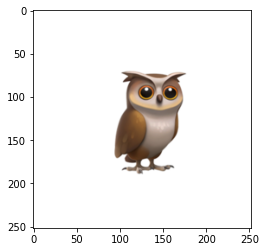

In [8]:
image, class_id, row, col = create_example()
plt.imshow(image);

In [9]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
  
  if norm:
    image *= 255.
    image = image.astype('uint8')

  image = Image.fromarray(image)
  draw = ImageDraw.Draw(image)

  row, col = gt_coords
  row *= 252
  col *= 252
  draw.rectangle((col, row, col + 120, row + 120), outline='green', width=3)

  if len(pred_coords) == 2:
    row, col = pred_coords
    row *= 252
    col *= 252
    draw.rectangle((col, row, col + 120, row + 120), outline='red', width=3)
  return image

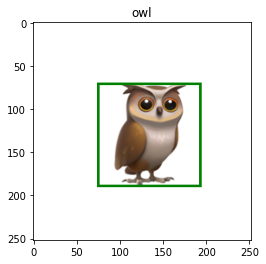

In [10]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(icons[class_id]['name'])
plt.show()

In [11]:
def data_generator(batch_size=16):
  while True:
    x_batch = np.zeros((batch_size, 252, 252, 3))
    y_batch = np.zeros((batch_size, 7))
    bbox_batch = np.zeros((batch_size, 2))

    for i in range(0, batch_size):
      image, class_id, row, col = create_example()
      x_batch[i] = image / 255.
      y_batch[i, class_id] = 1.0
      bbox_batch[i] = np.array([row, col])
    yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

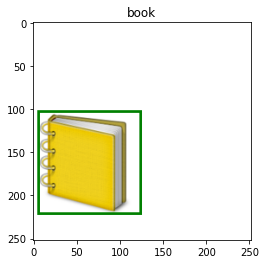

In [12]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(icons[class_id]['name'])
plt.show()

In [13]:
input_ = Input(shape=(252, 252, 3), name='image')

x = input_

for i in range(0, 5):
  n_filters = 2**(4 + i)
  x = Conv2D(n_filters, 3, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(7, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 252, 252, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 250, 250, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 250, 250, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
class IoU(tf.keras.metrics.Metric):
  def __init__(self, **kwargs):
    super(IoU, self).__init__(**kwargs)

    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
  
  def update_state(self, y_true, y_pred, sample_weight=None):
    def get_box(y):
      rows, cols = y[:, 0], y[:, 1]
      rows, cols = rows * 252, cols * 252
      y1, y2 = rows, rows + 120
      x1, x2 = cols, cols + 120
      return x1, y1, x2, y2
    
    def get_area(x1, y1, x2, y2):
      return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
    
    gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
    p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

    i_x1 = tf.maximum(gt_x1, p_x1)
    i_y1 = tf.maximum(gt_y1, p_y1)
    i_x2 = tf.minimum(gt_x2, p_x2)
    i_y2 = tf.minimum(gt_y2, p_y2)

    i_area = get_area(i_x1, i_y1, i_x2, i_y2)
    u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

    iou = tf.math.divide(i_area, u_area)
    self.num_ex.assign_add(1)
    self.total_iou.assign_add(tf.reduce_mean(iou))
    self.iou = tf.math.divide(self.total_iou, self.num_ex)
  
  def result(self):
    return self.iou
  
  def reset_state(self):
    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')


In [15]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    }
)

In [16]:
def test_model(model, test_datagen):
  example, label = next(test_datagen)
  x = example['image']
  y = label['class_out']
  box = label['box_out']

  pred_y, pred_box = model.predict(x)

  pred_coords = pred_box[0]
  gt_coords = box[0]
  pred_class = np.argmax(pred_y[0])
  image = x[0]

  gt = icons[np.argmax(y[0])]['name']
  pred_class_name = icons[pred_class]['name']

  image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
  color = 'green' if gt == pred_class_name else 'red'

  plt.imshow(image)
  plt.xlabel(f'Pred: {pred_class_name}', color=color)
  plt.ylabel(f'GT: {gt}', color=color)
  plt.xticks([])
  plt.yticks([])

In [17]:
def test(model):
  test_datagen = data_generator(1)

  plt.figure(figsize=(16, 4))

  for i in range(0, 6):
    plt.subplot(1, 6, i + 1)
    test_model(model, test_datagen)
  plt.show()

1/1 [==============================] - 0s 44ms/step


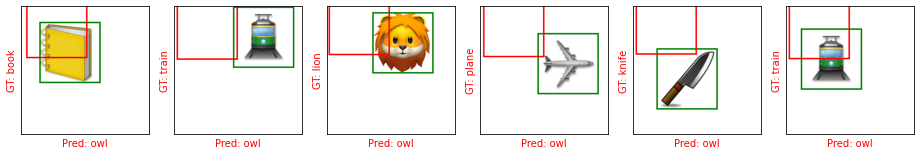

In [18]:
test(model)

In [19]:
class ShowTestImages(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

Epoch 1/20
1/1 [==============================] - 0s 46ms/step


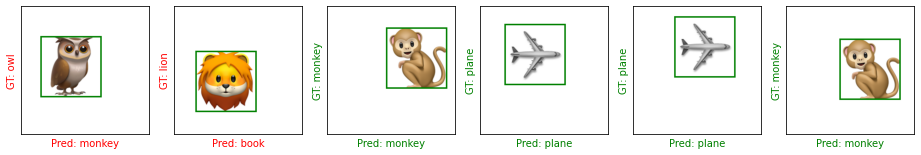

500/500 [==============================] - 760s 2s/step - loss: 1.5283 - class_out_loss: 0.2594 - box_out_loss: 1.2689 - class_out_accuracy: 0.9241 - box_out_iou: 0.3272 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - 0s 44ms/step


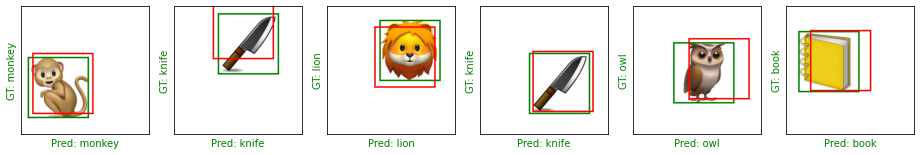

500/500 [==============================] - 899s 2s/step - loss: 0.0344 - class_out_loss: 0.0129 - box_out_loss: 0.0215 - class_out_accuracy: 0.9974 - box_out_iou: 0.3996 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - 0s 56ms/step


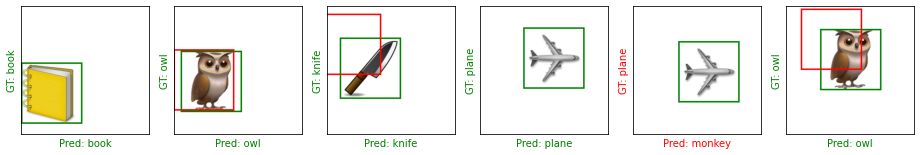

500/500 [==============================] - 783s 2s/step - loss: 0.0129 - class_out_loss: 0.0036 - box_out_loss: 0.0093 - class_out_accuracy: 0.9992 - box_out_iou: 0.4610 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - 0s 49ms/step


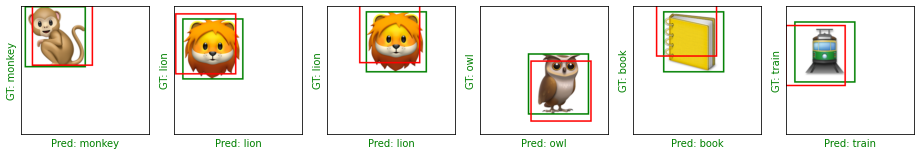

500/500 [==============================] - 724s 1s/step - loss: 0.0057 - class_out_loss: 6.8440e-04 - box_out_loss: 0.0050 - class_out_accuracy: 1.0000 - box_out_iou: 0.5123 - lr: 0.0010
Epoch 5/20
1/1 [==============================] - 0s 47ms/step


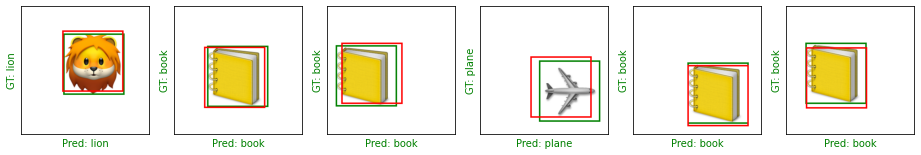

500/500 [==============================] - 721s 1s/step - loss: 0.0020 - class_out_loss: 3.9530e-04 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - box_out_iou: 0.5657 - lr: 2.0000e-04
Epoch 6/20
1/1 [==============================] - 0s 73ms/step


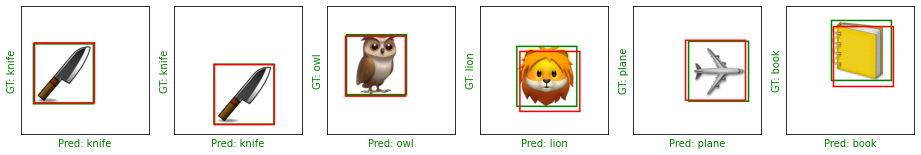

500/500 [==============================] - 719s 1s/step - loss: 0.0017 - class_out_loss: 3.2885e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.6037 - lr: 2.0000e-04
Epoch 7/20
1/1 [==============================] - 0s 43ms/step


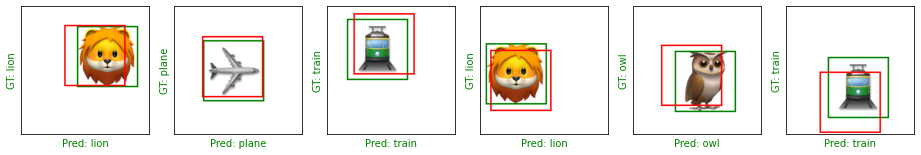

500/500 [==============================] - 718s 1s/step - loss: 0.0016 - class_out_loss: 2.6817e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.6319 - lr: 2.0000e-04
Epoch 8/20
1/1 [==============================] - 0s 48ms/step


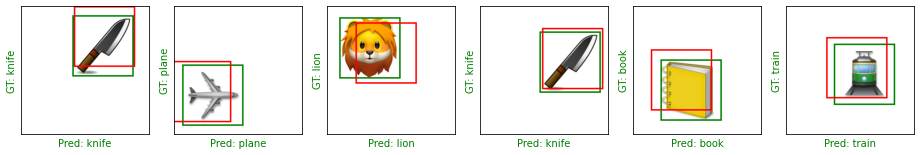

500/500 [==============================] - 726s 1s/step - loss: 0.0015 - class_out_loss: 2.5736e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.6534 - lr: 2.0000e-04
Epoch 9/20
1/1 [==============================] - 0s 48ms/step


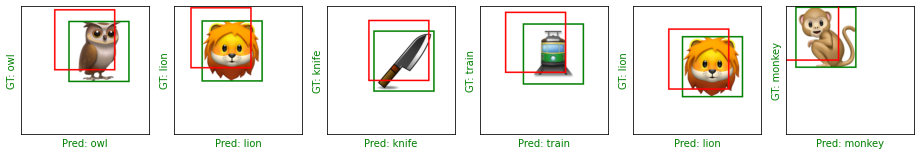

500/500 [==============================] - 725s 1s/step - loss: 0.0016 - class_out_loss: 3.4629e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.6701 - lr: 2.0000e-04
Epoch 10/20
1/1 [==============================] - 0s 45ms/step


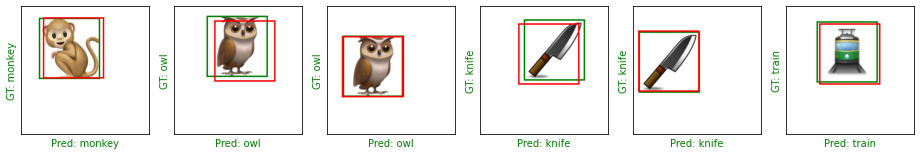

500/500 [==============================] - 718s 1s/step - loss: 0.0011 - class_out_loss: 2.4292e-04 - box_out_loss: 8.8775e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.6862 - lr: 4.0000e-05
Epoch 11/20
1/1 [==============================] - 0s 48ms/step


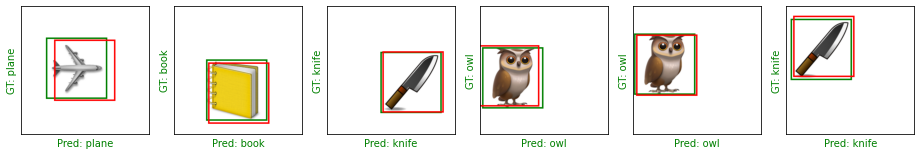

500/500 [==============================] - 721s 1s/step - loss: 9.8413e-04 - class_out_loss: 1.7148e-04 - box_out_loss: 8.1265e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7000 - lr: 4.0000e-05
Epoch 12/20
1/1 [==============================] - 0s 45ms/step


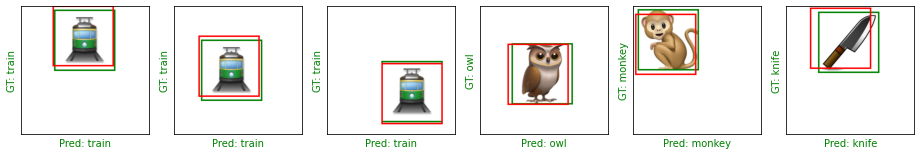

500/500 [==============================] - 724s 1s/step - loss: 9.0275e-04 - class_out_loss: 1.3578e-04 - box_out_loss: 7.6696e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7118 - lr: 4.0000e-05
Epoch 13/20
1/1 [==============================] - 0s 54ms/step


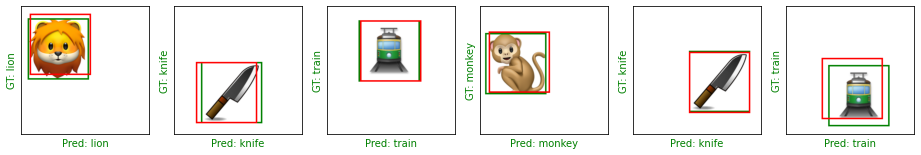

500/500 [==============================] - 718s 1s/step - loss: 8.5002e-04 - class_out_loss: 1.1350e-04 - box_out_loss: 7.3652e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7219 - lr: 4.0000e-05
Epoch 14/20
1/1 [==============================] - 0s 47ms/step


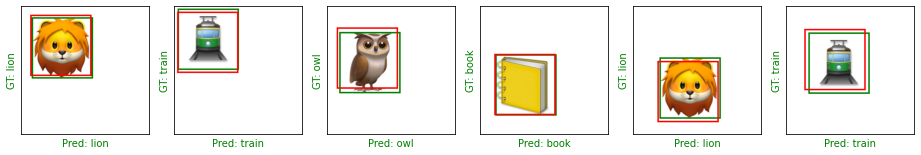

500/500 [==============================] - 722s 1s/step - loss: 9.3192e-04 - class_out_loss: 1.5769e-04 - box_out_loss: 7.7423e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7304 - lr: 4.0000e-05
Epoch 15/20
1/1 [==============================] - 0s 46ms/step


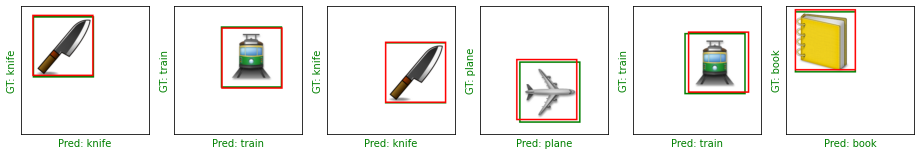

500/500 [==============================] - 725s 1s/step - loss: 7.4557e-04 - class_out_loss: 1.1145e-04 - box_out_loss: 6.3412e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7387 - lr: 8.0000e-06
Epoch 16/20
1/1 [==============================] - 0s 51ms/step


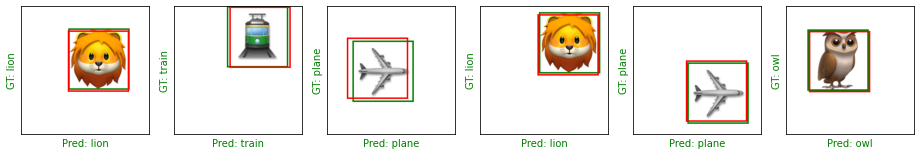

500/500 [==============================] - 721s 1s/step - loss: 7.2117e-04 - class_out_loss: 1.1116e-04 - box_out_loss: 6.1001e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7460 - lr: 8.0000e-06
Epoch 17/20
1/1 [==============================] - 0s 43ms/step


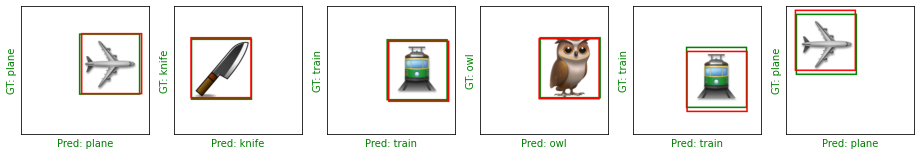

500/500 [==============================] - 691s 1s/step - loss: 7.0618e-04 - class_out_loss: 1.0939e-04 - box_out_loss: 5.9679e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7526 - lr: 8.0000e-06
Epoch 18/20
1/1 [==============================] - 0s 47ms/step


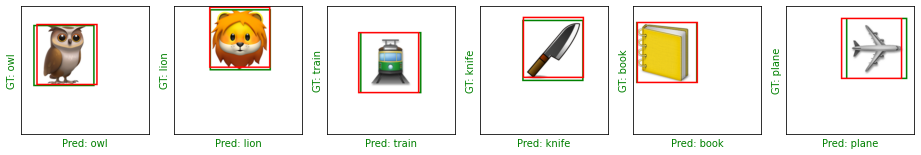

500/500 [==============================] - 686s 1s/step - loss: 7.1081e-04 - class_out_loss: 1.1062e-04 - box_out_loss: 6.0019e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7584 - lr: 8.0000e-06
Epoch 19/20
1/1 [==============================] - 0s 46ms/step


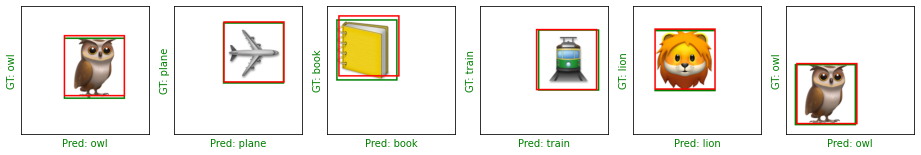

500/500 [==============================] - 687s 1s/step - loss: 6.7160e-04 - class_out_loss: 1.0230e-04 - box_out_loss: 5.6931e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7639 - lr: 8.0000e-06
Epoch 20/20
1/1 [==============================] - 0s 45ms/step


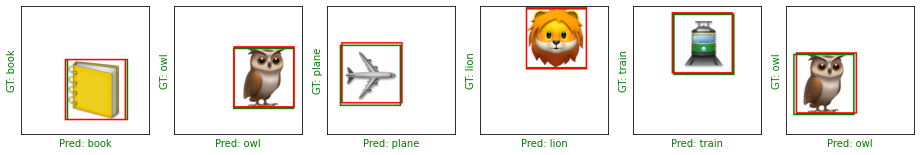

500/500 [==============================] - 686s 1s/step - loss: 6.6451e-04 - class_out_loss: 1.1099e-04 - box_out_loss: 5.5352e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7689 - lr: 1.6000e-06


In [20]:
def lr_schedule(epoch, lr):
  if (epoch + 1) % 5 == 0:
    lr *= 0.2
  return max(lr, 3e-7)


_ = model.fit(
    data_generator(),
    epochs = 20,
    steps_per_epoch=500,
    callbacks=[
               ShowTestImages(),
               tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

In [52]:
import PIL
from numpy import asarray
 
png_file = Image.open("/content/drive/MyDrive/icons/test-monkey-2.png").convert('RGBA')
png_file.load()
new_file = Image.new("RGB", png_file.size, (255, 255, 255))
new_file.paste(png_file, mask=png_file.split()[3])

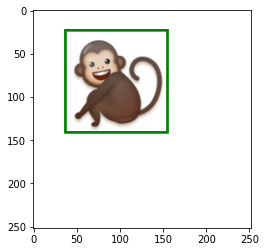

22 36


In [53]:
test_image = np.ones((252, 252, 3)) * 255
row = np.random.randint(0, 120)
col = np.random.randint(0, 120)
test_image[row: row + 120, col: col + 120, :] = np.array(new_file)

test_image = test_image.astype('uint8')

t_image = Image.fromarray(test_image)
draw = ImageDraw.Draw(t_image)

draw.rectangle((col, row, col + 120, row + 120), outline='green', width=3)

plt.imshow(t_image)
plt.show()

print(row, col)

In [54]:
test_image = np.expand_dims(test_image, axis=0)

test_x = test_image / 255.

1/1 [==============================] - 0s 47ms/step
[13.413795 21.525547]


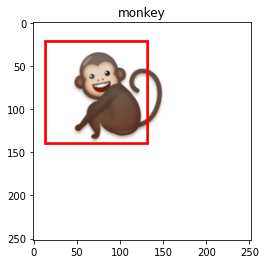

In [55]:
pred_y, pred_box = model.predict(test_x)

pred_coords = pred_box[0] *255

pred_class = np.argmax(pred_y[0])

image = test_x[0]


pred_class_name = icons[pred_class]['name']

print(pred_coords)

image = Image.fromarray(test_image[0])

draw = ImageDraw.Draw(image)

draw.rectangle((pred_coords[0], pred_coords[1], pred_coords[0] + 120, pred_coords[1] + 120), outline='red', width=3)

plt.imshow(image)
plt.title(pred_class_name )
plt.show()